<p style="font-size:3em">Predict buildings' energy consumption needs </p>

<br/>

This notebook corresponds to the second part of the **4th project of my data scientist path** with **OpenClassrooms/CentralSupelec** 

This project aims to provide the necessary skills to implement and optimise a supervised regression model 

This notebook contains the following steps:<br/>

* Models Training and comparing:
    * Create a median based dummy model (performance bottomline for our models)
    * Perform GridSearchCV optimisation on our chosen models : 
        * ElasticNet (=Ridge + Lasso regression)
        * Support Vector Machine(SVR)
        * Multi Layer Perceptron (MLPRegressor, with ealystopping)
        * **Bagging** : RandomForestRegressor from Sklearn
        * **Boosting** : GradientBoosting from Sklearn
    * Store results in a summary table
    * Choose best model based on RMSE score and task execution duration
* Observ the importance of ENERGYSTARScore Feature:
    * Use Feature Importance attribute of the chosen model
    * Use RFE (RecursiveFeatureElimination) function from sklearn.feature_selection
    * Create an homemade RFE algorithm 

___
<b>I strongly recommend to use the 'table of content' extension of Jupyter to navigate through this notebook </b>

# Imports

In [11]:
#import packages
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle

from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV,ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import dummy
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE,RFECV

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial,stats

import folium

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
pd.set_option('display.width', -1)

In [12]:
train= pd.read_csv("train2.csv")
test= pd.read_csv("test2.csv")

# train = train.drop(columns='ThirdLargestPropertyUseType_Manufacturing')
# test = test.drop(columns='ThirdLargestPropertyUseType_Manufacturing')


In [417]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3451 entries, 0 to 3450
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BuildingType_Consumption                      3451 non-null   float64
 1   NumberofBuildings                             3451 non-null   float64
 2   NumberofFloors                                3451 non-null   float64
 3   PropertyGFAParking                            3451 non-null   int64  
 4   PropertyGFABuilding(s)                        3451 non-null   int64  
 5   LargestPropertyUseTypeGFA                     3451 non-null   float64
 6   SecondLargestPropertyUseTypeGFA               3451 non-null   float64
 7   ThirdLargestPropertyUseTypeGFA                3451 non-null   float64
 8   ENERGYSTARScore                               2602 non-null   float64
 9   SiteEnergyUseWN(kBtu)                         3451 non-null   f

In [412]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BuildingType_Consumption                      1154 non-null   float64
 1   NumberofBuildings                             1154 non-null   float64
 2   NumberofFloors                                1154 non-null   float64
 3   PropertyGFAParking                            1154 non-null   int64  
 4   PropertyGFABuilding(s)                        1154 non-null   int64  
 5   LargestPropertyUseTypeGFA                     1154 non-null   float64
 6   SecondLargestPropertyUseTypeGFA               1154 non-null   float64
 7   ThirdLargestPropertyUseTypeGFA                1154 non-null   float64
 8   ENERGYSTARScore                               876 non-null    float64
 9   SiteEnergyUseWN(kBtu)                         1154 non-null   f

In [13]:
# We will need to compare our models with and without ENERGYSTARScore (ESS)
#Then to be able to compare correctly we need to use the same dataset 
# Let's drop the NaN remaining on ESS feature
train=train.dropna()
test=test.dropna()



In [14]:
#Let's drop the potential columns OHE with no inputs 
col_to_remove = train.columns[train.sum()<1]
train= train.drop(columns=col_to_remove)
test= test.drop(columns=col_to_remove)

In [15]:
print('Train: ',train.shape,'\nTest: ',test.shape)

Train:  (2602, 47) 
Test:  (876, 47)


## Mise en place des X_train et y_train 

Here is the construction of each data we will use for all models we will test

In [16]:
# Data without ENERGYSTARScore
X_drop_e= ['BuildingType_Consumption','ENERGYSTARScore','GHGEmissions(MetricTonsCO2e)','SiteEnergyUseWN(kBtu)']
X_drop_c = ['BuildingType_Emission','ENERGYSTARScore','GHGEmissions(MetricTonsCO2e)','SiteEnergyUseWN(kBtu)']

X_train_e = train.drop(columns=X_drop_e)
y_train_e = train['GHGEmissions(MetricTonsCO2e)']

X_train_c = train.drop(columns=X_drop_c)
y_train_c = train['SiteEnergyUseWN(kBtu)']

X_test_e = test.drop(columns=X_drop_e)
y_test_e = test['GHGEmissions(MetricTonsCO2e)']

X_test_c = test.drop(columns=X_drop_c)
y_test_c = test['SiteEnergyUseWN(kBtu)']



In [17]:
# Data WITH ENERGYSTARScore
X_drop_e_ESS= ['BuildingType_Consumption','GHGEmissions(MetricTonsCO2e)','SiteEnergyUseWN(kBtu)']
X_drop_c_ESS = ['BuildingType_Emission','GHGEmissions(MetricTonsCO2e)','SiteEnergyUseWN(kBtu)']

X_train_e_ESS = train.drop(columns=X_drop_e_ESS)
y_train_e_ESS = train['GHGEmissions(MetricTonsCO2e)']

X_train_c_ESS = train.drop(columns=X_drop_c_ESS)
y_train_c_ESS = train['SiteEnergyUseWN(kBtu)']

X_test_e_ESS = test.drop(columns=X_drop_e_ESS)
y_test_e_ESS = test['GHGEmissions(MetricTonsCO2e)']

X_test_c_ESS = test.drop(columns=X_drop_c_ESS)
y_test_c_ESS = test['SiteEnergyUseWN(kBtu)']


In [443]:
X_train_c.shape

(2602, 43)

In [547]:
X_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2602 entries, 0 to 3450
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BuildingType_Consumption                      2602 non-null   float64
 1   NumberofBuildings                             2602 non-null   float64
 2   NumberofFloors                                2602 non-null   float64
 3   PropertyGFAParking                            2602 non-null   int64  
 4   PropertyGFABuilding(s)                        2602 non-null   int64  
 5   LargestPropertyUseTypeGFA                     2602 non-null   float64
 6   SecondLargestPropertyUseTypeGFA               2602 non-null   float64
 7   ThirdLargestPropertyUseTypeGFA                2602 non-null   float64
 8   BuildingAge                                   2602 non-null   int64  
 9   LargestPropertyUseType_Entertainment          2602 non-null   i

In [546]:
X_test_c.shape

(876, 43)

In [8]:
#Here we create the table we need to populate with the performance of each model we study
summary_emission=pd.DataFrame(columns=['r2','best_param_r2','neg_root_mean_squared_error',
                                     'best_param_neg_root_mean_squared_error'])
summary_conso=pd.DataFrame(columns=['r2','best_param_r2','neg_root_mean_squared_error',
                                     'best_param_neg_root_mean_squared_error'])

In [19]:
#As we will use GridSearchCV, the study of our models will take time, 
#we will need to save our results and reload it there from time to time

summary_emission2= pd.read_csv("summary_emission2.csv",index_col='Unnamed: 0')
summary_conso2= pd.read_csv("summary_conso2.csv",index_col='Unnamed: 0')

# Models 

## Dummy Models

First point of information is to look at the score of a model which always predict the median of the train dataset :

### Consumption

In [433]:
dummy_model = make_pipeline(StandardScaler(),dummy.DummyRegressor(strategy='median'))



print('RMSE of Median based Model for Consumption: ',0-cross_val_score(dummy_model,X_train_c,y_train_c,cv=5,scoring='neg_mean_squared_error').mean())



RMSE of Median based Model for Consumption:  1.1747302901939065


### Emission

In [434]:
dummy_model = make_pipeline(StandardScaler(),dummy.DummyRegressor(strategy='median'))



print('RMSE of Median based Model for Emission: ',0-cross_val_score(dummy_model,X_train_e,y_train_e,cv=5,scoring='neg_mean_squared_error').mean())

RMSE of Median based Model for Emission:  1.8646778855508095


## Regression with regularization (Elastic Net)

For each model we will use the same pattern : 
   * parameters : dictionnary containing the hyperparameters of each model 
   * scoring : we will check 2 scores : r² and RMSE
   * model_pipe : pipeline containing StandardScaler + the studied Model 
   * model_grid : GridSearchCV using our parameters,scoring and pipeline 
        
Then we create 2 for loop : 
   * the first one itterates on scoring (here 0 = r² and 1=RMSE)
   * the second one itterates on targets (here 0 = emission and 1 = consumption)
    
In this loop we will fit the GridSearchCV for the current score and the current target, once done we write the results (best score and best params) in the corresponding summary table

In [436]:
parameters = {"elasticnet__alpha": np.logspace(-5,5,50),  #alpha, coef which multiply the penalty term
              "elasticnet__l1_ratio": np.arange(0.0, 1.0, 0.1), #l1_ratio=1 means Lasso reg., l1_ratio 0 means Ridge reg.
              "elasticnet__tol":[0.1,0.01,0.001,0.0001]} #Corresponds to the level of change needed on the loss function
                                                         # to continue to itterate

scoring=['r2','neg_root_mean_squared_error']


elastic_pipe = make_pipeline(StandardScaler(),ElasticNet())

for i in range(len(scoring)):
    for k in range(2):
        print('k= ',k,'\ni= ',i,'\n___')

        elastic_grid = GridSearchCV(estimator = elastic_pipe, 
                              param_grid = parameters,
                              scoring = scoring[i],
                              cv=5)

        if k == 0  :
            elastic_grid.fit(X_train_e, y_train_e)
            
            #Write score in summary table
            summary_emission.loc['ElasticNet',scoring[i]]=elastic_grid.best_score_
            
            #Create a dict of best params
            a={'alpha':elastic_grid.best_params_['elasticnet__alpha'],
               'l1_ratio':elastic_grid.best_params_['elasticnet__l1_ratio'],
               'tol':elastic_grid.best_params_['elasticnet__tol']}
            
            #Write the string form of the best params dict
            summary_emission.loc['ElasticNet','best_param_'+scoring[i]]=str(a)
            
        else: 
            elastic_grid.fit(X_train_c, y_train_c)
            summary_conso.loc['ElasticNet',scoring[i]]=elastic_grid.best_score_
            a={'alpha':elastic_grid.best_params_['elasticnet__alpha'],
               'l1_ratio':elastic_grid.best_params_['elasticnet__l1_ratio'],
               'tol':elastic_grid.best_params_['elasticnet__tol']}
            summary_conso.loc['ElasticNet','best_param_'+scoring[i]]=str(a)





k=  0 
i=  0 
___


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.2640576792355, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.7848548764189, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.2217304312064, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.5507716066986, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861.3838372102704, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 884.893546453714, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.8115384421924, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.3351382381702, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.5243424076302, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.712267275908, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.0036933459496, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.4136636367107, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.04924583582624, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.5044520028282, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.4817248322712, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.24526422461315, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445.1887577743511, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.9523288599182, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 400.9129299428805, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416.75433663202364, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.56374586165305, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.8763086157635, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.272731191829, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.7932667565033, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.2572826431184, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.9524988656085, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.4984694920795, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 628.7749959681834, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.4055030753667, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.9856173974638, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.76641567462457, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.3879899458706, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.6324705102005, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.35796080416117, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.82458515252813, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.62801182781027, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.43707238015975, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418.9459517159477, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423.00138840238924, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.8909043522688, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.2862630397588, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.8063807946928, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 874.6906372348114, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 883.865782949466, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 848.1654670395399, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.7561624298406, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.2914618806326, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.8880929456036, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.100515614567, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 571.7181357587115, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.5237263858468, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.8937131513393, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480.40118230792405, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.04624618843354, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.2739660738056, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417.8812260530551, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.9048071590206, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394.45881508302557, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397.5476032370609, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 400.0937305033922, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 842.7003188668577, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.585584026298, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.1807124973074, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.1756940475454, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.7660154569721, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.8230115523526, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.764142376385, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.3702193715071, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.1061611127222, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.94762343519665, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.7296045475847, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.26733450542736, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418.61226334755384, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412.5999573936557, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416.1452838629118, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.1011919717977, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.3384646171019, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.8568481984196, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861.2236511958972, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.6712463282332, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.607063298861, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.1471582238155, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.3450942549562, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.7626485695255, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.6294732895536, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.1589449609696, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.7645447186948, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.1491652038045, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458.9171860785849, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.4362994130074, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.8173093306822, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409.80333174902455, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.3438967965276, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.384467802529, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.9011367682367, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.3407527070678, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 826.1191058948532, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 829.1581020850674, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846.8945872292542, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 594.1801472418831, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.9629557984925, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.0761436665177, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.2724780283334, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.8110400162961, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.3069175177577, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 449.60284762030426, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.07736467518407, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 461.48704366624463, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405.3211854602906, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.8381015078003, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412.80346743263965, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.9636511193553, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.4043439869092, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.507256597703, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 802.3666601366251, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 821.538030057484, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.8413991261327, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.0026622585602, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.8682699063511, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.763127565197, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.8202193840275, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4190449340674, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.521791370424, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.68004963368446, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439.0695625428285, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446.4196106638651, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404.1328065331444, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398.11700042732286, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.59498921715567, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1047.0497489313589, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.4915072010738, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.6039356989918, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.1898150569959, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.217121705735, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.4499278794203, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.322692584848, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.3074415052604, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.45399103828, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.69288604327471, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.6132247313219, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.7057751007677, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.505102161548848, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.044068344396464, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.033718908534638, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.6693435366772, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1047.1706997640752, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.613436816326, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555.028829123788, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.3784161321489, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.97157663536905, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.9044072142026, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.43904815011592, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.44017990835937, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.022017761676125, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.446096933313584, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.298285779050502, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9399690597608696, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.081103410067044, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.786001604946478, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.2969433923424, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.99173234781654, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.64358097232616, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.53507702553156, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.18644363377575, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.2847725383433, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.0195345413988, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.305443322940846, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.13324224669827, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.382614069144665, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.619868122442995, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.666265657112262, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053.284540087284, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1071.851862668187, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.1996772816124, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.82845706080798, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.37051685481492, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.91545911372532, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.999666837978566, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.398247802167134, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.32969758939953, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.117821403823882, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.96422286984216, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.31054449883095, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.7522578028547, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1048.1784812234698, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.6294867626953, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.70290552244228, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.634113243763295, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.562107986985666, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.214457191454812, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.230185751407362, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.325678326517163, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1073.353052985923, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1041.6419620268625, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1049.0062240874224, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5663838058530928, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6737977755065003, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6060852697653445, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6999637152489413, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8895266144704692, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043.0514503583256, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6209292317821564, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.978432596444236, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7125789061847172, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1055.6138802468975, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054.1055309178164, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1062.0126593838816, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054.0535542991545, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1060.6036482912386, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1059.1024792756625, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.0389478226346, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079.4379888476003, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1077.8721514546107, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1124.2148057084294, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091.1531383073884, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1095.6720744037204, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146.4655528530204, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1148.8431735049355, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146.0855241210143, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186.9827014968405, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188.598644736001, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1184.4730055449706, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1296.60606381952, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1299.8378822502193, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1289.582114514302, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409.4535813288815, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1365.0029191081305, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1371.7981829075588, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458.3400771683198, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1490.1968092132322, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1520.125548623287, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1619.544695921636, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1663.0348844168213, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1599.4236085211073, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1744.306240520695, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1736.1412691086712, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1786.1264224554232, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1810.7458637042516, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870.7324381806532, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1786.2514825939322, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1849.0817202231608, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1912.5806638369136, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1849.5735474246994, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1894.4050169731545, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1962.1134216337073, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1867.25110913503, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871.2263986504913, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1906.4587246334877, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.295520815745, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1883.7129695798583, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1919.2264032241872, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1989.2620528301638, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969.2680895008464, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886.794609096722, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1922.378868310177, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1972.8977320070735, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1889.9574672809456, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1925.6150230513285, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1898.0976422774345, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1973.776131686515, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1890.7228517496392, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1898.8657473208923, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974.6706725213492, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.5022807322027, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1998.1917823328058, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.0507085725174, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974.8860848156517, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1927.5831617684373, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1998.405400402563, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.2386998361392, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1998.456778801306, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.2839140891656, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.157686843333, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1998.5089745376627, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.3298474174403, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.2111833072759, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

k=  1 
i=  0 
___


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.0677554908469, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.848071052423, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.77393442602056, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.2851136567539, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.0907010303364, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.75380565689215, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.08338425565137, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.78818673067633, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.72846193058854, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.6816437054576, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.42805619507754, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.2188451340649, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.32487401222767, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204.71655259704147, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.14937881258248, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.65707625901405, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.915279145669, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.77635414876244, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.0727157727306, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.85283845194084, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.7786921456836, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410.07617722200786, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363.8903636062789, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.0472906575251, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.8299755879627, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.90051391792736, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.7394900656716, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.20132292596395, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.7909511923413, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.6941463703863, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.71712655258636, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204.05401625473633, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.51428469315493, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.37480270580352, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.59232877802015, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.4779417162976, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.08046234732006, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.86029118590756, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.7861112790585, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.68495153463186, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.96193720041674, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.11778597917737, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.0671282430509, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.1793860743327, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.05131769083516, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.4491890773653, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.75439476989567, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.74982831374814, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.24688959897884, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.76252004243895, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.4503098514349, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.38132288341086, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.49038813449715, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.6217272261116, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.4386292843995, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.3114922348542, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.0924001238566, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.0135753841374, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.23757840717093, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.61213078948566, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274.24940439206455, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.4124418389645, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249.33512787532592, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.76200181690996, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227.95832226926433, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.40749002042116, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.32142748155354, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.35710206662583, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.19278805757705, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.57028469147656, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.1218992568841, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.10282868357785, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368.1725101526986, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.1697809643869, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.3537226923644, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.67918473117334, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.017403671328, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293.3756232602468, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.10149887428844, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.75095760492763, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.3888967431244, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.6374893023991, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.76460426364406, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.27825942718624, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.0044711374852, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.0731993768553, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.02118668046126, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.8398125099964, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.48731871064945, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.35974526136346, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.0040696003075, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.23623122180976, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.66732133681955, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256.2390374615449, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.38370451709227, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.74314221217918, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.23349561505825, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.2055875607125, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.87698353804888, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.24963039548095, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.22141616460084, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.32003179870469, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.4748669076372, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.09278009676854, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.1749208384705, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.7918845649228, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.90065336270084, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.6687405318453, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.97468576289646, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.92949183366045, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288.63576630686316, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.24931923977726, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.19860643869941, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.45295270199063, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.69557974595745, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.485655527304, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.046586902017907, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.9245878535299, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.58098780682707, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.45632694974705, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329.5482102930325, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.5522314455263, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318.248736295321, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.17276727597437, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.4912473712493, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.7033610999223, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.834521995754017, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.377962094501413, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.980388522199405, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0003888656364097, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3369061971305882, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4646662293050667, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234.4284819008762, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.59186886132488, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.00221162545165, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.33108560289622, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.19025620062132, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.13925684949993, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.821194429558773, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.729108883626736, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.997517290220458, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1047107982002444, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8220981548372492, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1267897215117273, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.6408237518243, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174.2104045281904, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.0055852488311, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.8145293515164, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.36792369345915, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.30475957996293, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.069956918005346, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.878098263355128, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.124277800486425, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.506163258753304, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7715269557170359, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5446275737207316, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.09842963594781, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.5344236724286, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.72594357685, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.110569725358118, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.499730893062065, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.729401690762757, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.787625260522077, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.511331126600339, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.051241223841998, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.7086533127392, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.5805155736526, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.28067116814935, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.925543152272553, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.209086701002889, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.507439396228619, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5822035410787976, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.818061152727978, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3663012467333147, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.0633866382771, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.80099768932075, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.74683624359636, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3965870170909511, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45142954813150027, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5268831703141359, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.82918825533915, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.62553513597703, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488.612611739417, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 467.3300437401984, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.0356947090752, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.92292607412355, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.09794655021926, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.6501617924815, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.34482953332054, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 479.82990133646035, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.0698787949211, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.36876538410246, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.85996681343937, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.65700420889823, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.75584192167486, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.2033131884293, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 504.077774815028, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.2286376388327, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.0851758689436, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.0765997089271, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.0941655313137, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.6578643476239, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.1180023954045, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.5946555286521, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640.1777929205829, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 657.0849972998595, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.2391541039949, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692.2376156677904, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 710.368949559984, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.7521332804254, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 823.7769803988501, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846.0171739735227, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.6530971702497, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897.573958160494, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 922.6005396154852, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 886.4816437418231, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1033.0767157547468, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1063.7328726590185, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1015.8110402955604, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1084.8806870372212, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117.7954441899428, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1064.9889556567607, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151.6927544126386, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1187.5707041954604, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1128.185900868272, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1170.5886597293386, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1207.3121084071704, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146.0118698840686, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1191.1627140206087, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228.8095861540344, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165.3968890175881, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1141.8357141095546, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.3340617149702, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1234.2134501918224, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1201.6812000676425, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239.8011677037523, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1175.2977431375898, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1241.159708910122, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1176.5209753101005, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1217.2126384975995, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1204.3075516379913, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1242.5457413268784, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.7688481760792, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149.5395620789, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1204.6273048770022, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1242.8798903694171, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1204.9524442480927, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.2196685865824, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.375557437355, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.3014128536818, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.4491466473448, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219.3585301426867, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.1101418317553, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.384466434529, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.523914145846, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.1292523257384, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.4044373789222, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.5418925700712, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

k=  0 
i=  1 
___


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.2217304312064, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.3030067851635, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.866947799782, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 884.893546453714, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 901.673059063949, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 889.1169483477892, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.5243424076302, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.5983328617909, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 658.2785736855851, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.4136636367107, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611.4572055163919, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.9868077030225, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477.23545155161185, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.04924583582624, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.5044520028282, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445.1887577743511, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.9523288599182, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.05561898502344, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416.75433663202364, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.56374586165305, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.28583919393805, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.8763086157635, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.4988501441225, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 859.3417600438843, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.9524988656085, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.4984694920795, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.8422099242066, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.9856173974638, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.6483733462388, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.9184325322077, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513.3957826739025, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.81446212164576, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.76641567462457, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.18599357728624, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 449.89634832903187, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445.84644459003755, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418.9459517159477, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423.00138840238924, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.4855007011158, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.8909043522688, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.2862630397588, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.8063807946928, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.8511564669484, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.1447050173405, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.6727304260476, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.3438810699831, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 624.9806777726728, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.7561624298406, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.03424461927284, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.5452934964168, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.57895421743626, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.3591201134093, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.8937131513393, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480.40118230792405, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414.34543345791224, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417.8812260530551, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.9048071590206, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.8265328166124, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.264497360371, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.3510126383171, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 842.7003188668577, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 850.585584026298, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 853.1807124973074, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616.0124855763397, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.4112406522308, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.2336330816609, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.0255175043919, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.2309315561562, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.764142376385, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.74462920118015, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.3366947185641, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.94762343519665, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.14654985386153, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.58514785574334, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418.61226334755384, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.2955312945537, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.385790870472, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1070.947103953462, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 844.2956424404614, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861.2236511958972, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.6712463282332, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609.6849838755868, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623.382853344217, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 636.710703574257, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540.6294732895536, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.1589449609696, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.7645447186948, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.1491652038045, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458.9171860785849, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.4362994130074, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409.80333174902455, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.3438967965276, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417.3256142104732, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.9011367682367, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.3407527070678, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.4363676604573, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.613254965523, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 683.3735279166144, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.7999503635472, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.3144654094694, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 594.1801472418831, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.9629557984925, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.18208316923744, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.48524881750234, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.48341321844487, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.84098030280586, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.2980084822391, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424.61777812329774, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412.80346743263965, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428.10667422537995, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.5304893688834, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.507256597703, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1071.066243228818, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.4497704357937, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.9863861573212, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 685.7764593755219, tolerance: 399.7084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.6838501352463, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.8682699063511, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.763127565197, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.5162231639713, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.0036270700498, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 491.58942337373674, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468.47818634878956, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 437.66788846908014, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419.25894153323884, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.5732670208348, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.73040188077448, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389.9240068480756, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392.43856416249116, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 755.4992860976679, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.4644119833696, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.9967719573582, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.9688763582385, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 607.1898150569959, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.217121705735, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.3901631048343, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.4934320903152, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485.0145014800671, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.69288604327471, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.6132247313219, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.7057751007677, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.38588304064092, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.314150784864978, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.35348650921469, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1071.2981384060759, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 686.176304556503, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.262509512217, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.63387315540933, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555.028829123788, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.65885591406027, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.4250153239916, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.08201547951876, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.08846271353787, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.835846902612502, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.142130704245346, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.90687618928314, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1047.3558851795824, tolerance: 395.0490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.799898162132, tolerance: 378.4006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.9431656188942, tolerance: 385.5416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.38081119822823, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.2969433923424, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435.99173234781654, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115.04502259537207, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.64695797719878, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.16343442654352, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.98303478529192, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.439790639571584, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.995858603420402, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.17783291292767, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3196570636973775, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.27675973911505, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.67026792346837, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.2467470417655, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.76036998246786, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.517092451638064, tolerance: 39.97084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.39463774815795, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.003588325176, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.480670846664452, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.437449138750935, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.990162837057369, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.853836202599723, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0916784108794673, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.7522578028547, tolerance: 379.87186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.50363808198085, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.81977912552816, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.74095773367321, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.487456485832126, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.676742229674346, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.36375136450647, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5619058914651305, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2530715004536432, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7604750641346527, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054.7699417661265, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1073.353052985923, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2400733295487498, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8857273276444175, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.103102210110137, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0312103865639983, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1056.2161343913106, tolerance: 3.8554168173047136
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.815998885365, tolerance: 3.997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043.0514503583256, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.2688952525589, tolerance: 3.7987186082003372
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.3840773865732, tolerance: 3.9504909804658515
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1050.8633085867798, tolerance: 3.7840062376433172
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1048.7271407045378, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1055.6138802468975, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054.1055309178164, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1062.116063701672, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1068.183626359055, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1066.6716462561305, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079.4379888476003, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1077.8721514546107, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1087.676619153908, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1114.8631621430573, tolerance: 37.987186082003376
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1118.322332199172, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1116.274140171376, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146.4655528530204, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1148.8431735049355, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146.0855241210143, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1238.7156868839718, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232.2080003106223, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1252.5514968334387, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1296.60606381952, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1299.8378822502193, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1289.582114514302, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1453.2213018123664, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1430.4441633699996, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458.3400771683198, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1509.5427522843502, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1538.9916772913552, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1576.318461648694, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1713.7032228752241, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.9424642579556, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1694.5924795798123, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1736.1412691086712, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1786.1264224554232, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1726.6629272457094, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886.9967669938287, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1815.0047049199593, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1849.0817202231608, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1841.5042180876233, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1876.1040609004276, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1942.106069132652, tolerance: 0.3997084894750452
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1951.407987096274, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871.2263986504913, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1906.4587246334877, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886.3940183283141, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1960.150262514978, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878.84787345786, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969.2680895008464, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886.794609096722, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1922.378868310177, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1971.4970803710316, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1888.7369837441083, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924.3661830619412, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1973.776131686515, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1890.7228517496392, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1926.398237084026, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974.3263238830614, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.2022461516146, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1926.8888173344317, tolerance: 0.3855416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974.8860848156517, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.689970214151, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1927.3879361626841, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.1663776099576, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.0207979861225, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.8073456785164, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.157686843333, tolerance: 39.50490980465852
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.9266163519385, tolerance: 37.840062376433174
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1927.6301163925075, tolerance: 38.55416817304714
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899.312178959168, tolerance: 0.37987186082003377
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975.1906056410917, tolerance: 0.39504909804658517
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1891.9552982891926, tolerance: 0.3784006237643317
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

k=  1 
i=  1 
___


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.0677554908469, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.848071052423, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.77393442602056, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.2851136567539, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.0907010303364, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.75380565689215, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.08338425565137, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254.78818673067633, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.72846193058854, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.71311414555174, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.6816437054576, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.42805619507754, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.32487401222767, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204.71655259704147, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.14937881258248, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.65707625901405, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.915279145669, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.77635414876244, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.85283845194084, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.7786921456836, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.416578326735, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.0472906575251, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.2716578871614, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.32975466897415, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.7394900656716, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.6141212046052, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272.2149664813936, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.39039384614705, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.72289410967875, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.99123894799067, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.1241291802868, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.4798594975137, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.209134157783, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.67183973779441, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.8219462419613, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.6018631422853, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.86029118590756, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.7861112790585, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.425294609594, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.96193720041674, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.11778597917737, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.9351017071599, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.05131769083516, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.86328673994785, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.51411553639014, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222.80347252775283, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.059706054333, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.4491890773653, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.58580736734962, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.24688959897884, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.76252004243895, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.23475592575687, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.92225602132083, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.49038813449715, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359.19458051419883, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.8277812736691, tolerance: 241.0322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.62864599383227, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.23757840717093, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313.61213078948566, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.06706506651153, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.24029005080672, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.91179900696096, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.68725921454268, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.17105741431112, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.39198372666482, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.88156115292264, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.32798520664443, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.23798616902883, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.5930776665029, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.8892215475342, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.81468895645975, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.4585467517202, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355.3537226923644, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.54529642583555, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.94441961708105, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263.3755830071186, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.7159492887895, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.95207864241496, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.48494003444142, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.5969483570758, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214.13339345668533, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.45257954849887, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.39482622529488, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196.28194807021146, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.35554172328915, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.0071752886709, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.569246847719, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.48731871064945, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.35974526136346, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.7387878958533, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.22930658823645, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.3237710128129, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285.7226747141515, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.3377495164724, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.85629131601257, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.01303874556055, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.12423364469822, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.54945863008538, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.47873794193083, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5250754365144985, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.10183515959494, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.0598929412837, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.5272425283784, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.4002848123487, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.1749208384705, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.7918845649228, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347.90065336270084, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.6687405318453, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.46443767838952, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.040281838351, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.18221705236226, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.54826142557198, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.45006719210983, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.782316411628244, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.88977509551415, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3856893111042154, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4305383719512292, tolerance: 2.3000706299418643
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.00409766817427, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.9245878535299, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.58098780682707, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.4760337530961, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.54819976843493, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.8022863343461, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.79952308340569, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.42712914576646, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.33383222376165, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.590765502768477, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.099959566910798, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.022060767233256, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.30404485325823, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.0791784088467, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.9942271332452, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.01451404748423, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.91625010768342, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.15320519151436, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.618912577142396, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.15245538210331, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.01142145783285, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.743917140999429, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.815147086973639, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.927894648559686, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.65730876203844, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.4215987832599, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.1954877040203, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174.2104045281904, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.81959247301063, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.07345348428714, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.8145293515164, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.36792369345915, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.421579339111872, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.194816895519693, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.993857500263175, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.351032808067316, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.8606974953859, tolerance: 248.6875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.61709760384684, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.3884545872567, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.29510311675983, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.43178546019351, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.344388924054897, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.750540367638223, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.63493786948186, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.589282554031001, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6686438406941306, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4277474684909066, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.675393485716768, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473.9421738651236, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.7086533127392, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.5805155736526, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.811844922127193, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0613325583379947, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0674020235543367, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9355621092925048, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.095291602419593, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5022149224560053, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4636735691373133, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4732565881234905, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23961646247300905, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6191752520038563, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7244618583276861, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6850480818985716, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.62553513597703, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488.612611739417, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2463125831944808, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.92292607412355, tolerance: 2.410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.97439344486224, tolerance: 2.486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.60434461966986, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.34482953332054, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.92070577190856, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.94740865865646, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477.18274796571495, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.24261841334277, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.8103410807218, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493.75584192167486, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.1955011140366, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.78274111140655, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.5197943606511, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.4815431668862, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513.3525141658714, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538.0941655313137, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.7520113634744, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 531.1579106109539, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.6316614459541, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.0370321923043, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.7612266191277, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638.2391541039949, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.102026102582, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623.5574332025681, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 748.4297398512829, tolerance: 23.571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.6229175838089, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.4146210832722, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did no

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 815.6530971702497, tolerance: 0.2357143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.3826957180793, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793.4917962933523, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 971.5016749560334, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8771166329375, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 969.3559512158736, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 989.5565915810862, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1033.0767157547468, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1063.7328726590185, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1134.2886045972898, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.4431567253487, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1123.936099361853, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1163.4407538781131, tolerance: 0.2438990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1100.3094645037513, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1151.6927544126386, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.3579034311263, tolerance: 24.38990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1129.5116706630815, tolerance: 23.000706299418646
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1183.0747763415952, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1137.0301565367315, tolerance: 0.23000706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1191.1627140206087, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228.8095861540344, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective d

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1199.6130762183104, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1237.6399758700954, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1173.351578367973, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did n

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1201.6812000676425, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239.8011677037523, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1176.5209753101005, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1242.0118933169092, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1177.288227514593, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1218.0665186255585, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.0696723012124, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1218.9362028783096, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149.5395620789, tolerance: 230.00706299418644
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.0889337917802, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.2578643237553, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219.1456466020782, tolerance: 2.4389902169583277
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.2196685865824, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.4491466473448, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219.3585301426867, tolerance: 243.8990216958328
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.0795702782893, tolerance: 24.10322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.3525184001658, tolerance: 24.86875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.4951535483692, tolerance: 2.3571437323413846
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205.1101418317553, tolerance: 0.2410322226725759
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243.384466434529, tolerance: 0.2486875465928405
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1178.5418925700712, tolerance: 235.7143732341385
  positive)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did 

In [478]:
#Save the consumption best estimator (which will be useful to study model run time)
with open('models\elasticnet.pickle', 'wb') as file:
    pickle.dump(elastic_grid.best_estimator_, file)

## Support Vector Machine (SVR)

In [446]:
parameters = {"svr__gamma": np.logspace(-5,5,20),  #Kernel Coef
              "svr__C": [1, 10, 100, 1000], #Regularization Parameter
              "svr__epsilon": [0.001,0.01,0.1,1]} #Epsilon tube around the found hyperplan 

svr_pipe = make_pipeline(StandardScaler(),SVR(kernel='rbf'))

scoring=['r2','neg_root_mean_squared_error']



for k in range(2):
    for i in range(len(scoring)):
        print('k= ',k,'\ni= ',i,'\n___')
        svr_grid = GridSearchCV(estimator = svr_pipe, 
                          param_grid = parameters,
                          scoring = scoring[i],
                          cv=5)
        if k == 0  :
            svr_grid.fit(X_train_e, y_train_e)
            #Write score in summary table
            summary_emission.loc['SVR',scoring[i]]=svr_grid.best_score_
            
            #Create a dict of best params
            a={'gamma':svr_grid.best_params_['svr__gamma'],
               'C':svr_grid.best_params_['svr__C'],
               'epsilon':svr_grid.best_params_['svr__epsilon']}
            
            #Write the string form of the best params dict
            summary_emission.loc['SVR','best_param_'+scoring[i]]=str(a)
            
        else: 
            svr_grid.fit(X_train_c, y_train_c)
            summary_conso.loc['SVR',scoring[i]]=svr_grid.best_score_
            a={'gamma':svr_grid.best_params_['svr__gamma'],
               'C':svr_grid.best_params_['svr__C'],
               'epsilon':svr_grid.best_params_['svr__epsilon']}
            
            summary_conso.loc['SVR','best_param_'+scoring[i]]=str(a)

k=  0 
i=  0 
___
k=  0 
i=  1 
___
k=  1 
i=  0 
___
k=  1 
i=  1 
___


In [479]:
#Save the consumption best estimator (which will be useful to study model run time)

with open('models\svr.pickle', 'wb') as file:
    pickle.dump(svr_grid.best_estimator_, file)

## MLP 

Here is the only exception in our pattern : 
Instead of using a gridsearchCV, here we will use and early stopping : 
 * The training will stop once validation score does not improve by 'tol' value here (0.01), in 10 itterations (defaultvalue) 
 * We will use a 20% validation fraction here
The rest of the pattern is exactly the same

In [469]:
parameters = {"hidden_layer_sizes": [(10,10,10),(20,20,20),(30,30,30)],  #Setting for layer between first and last layer
             "max_iter": [50,100,200,500], # NUmber of time the data goes through the MLP 
             "batch_size" :[100,200,500], #Size of minibatches for stochastic optimizers
             "learning_rate_init": [0.0005,0.001,0.005]} #Step for the Gradient descent

param=ParameterGrid(parameters)
# for par in list(param):
#     print(par)

In [450]:
std_scaler = StandardScaler()

X_train_e_scaled =std_scaler.fit_transform(X_train_e)
X_test_e_scaled = std_scaler.transform(X_test_e)

X_train_c_scaled =std_scaler.fit_transform(X_train_c)
X_test_c_scaled =std_scaler.transform(X_test_c) 


parameters = {"hidden_layer_sizes": [(10,10,10),(20,20,20),(30,30,30)],  
              "max_iter": [50,100,200,500],
             "batch_size" :[100,200,500],
             "learning_rate_init": [0.0005,0.001,0.005]} 

parameters=ParameterGrid(parameters)

best_score_e_r2 = 0
best_score_e_rmse = +999

best_score_c_r2 =0
best_score_c_rmse = +999

done = 0 

for param in parameters:
    
    
    mlp = MLPRegressor(early_stopping=True,validation_fraction=0.2,tol=0.01)
    mlp.set_params(**param)
    
    for i in range(2):
        
        
        if i ==0:
            mlp.fit(X_train_e_scaled,y_train_e)
            y_predict = mlp.predict(X_train_e_scaled)
            
            #If a better R² score is found for Emission, save it here (model + param)
            if r2_score(y_train_e,y_predict)>best_score_e_r2:
                best_score_e_r2 = r2_score(y_train_e,y_predict)
                best_params_e_r2 = param
            
            #If a better RMSE score is found for Emission, save it here (model + param)
            elif math.sqrt(mean_squared_error(y_train_e,y_predict))<best_score_e_rmse:
                best_score_e_rmse = math.sqrt(mean_squared_error(y_train_e,y_predict))
                best_params_e_rmse = param
        

    
        else:
            mlp.fit(X_train_c_scaled,y_train_c)
            y_predict = mlp.predict(X_train_c_scaled)

            #If a better R² score is found for Consumption, save it here (model + param)
            if r2_score(y_train_c,y_predict)>best_score_c_r2:
                best_score_c_r2 = r2_score(y_train_c,y_predict)
                best_params_c_r2 = param
            
            #If a better RMSE score is found for Consumption, save it here (model + param)
            elif math.sqrt(mean_squared_error(y_train_c,y_predict))<best_score_c_rmse:
                best_score_c_rmse = math.sqrt(mean_squared_error(y_train_c,y_predict))
                best_params_c_rmse = param
        

    
    done+=1    
    print('Et de {}!'.format(done))                  

    
summary_emission.loc['MLP','r2']=best_score_e_r2
summary_emission.loc['MLP','neg_root_mean_squared_error']=-best_score_e_rmse

summary_emission.loc['MLP','best_param_r2']=str(best_params_e_r2)
summary_emission.loc['MLP','best_param_neg_root_mean_squared_error']=str(best_params_e_rmse)

summary_conso.loc['MLP','r2']=best_score_c_r2
summary_conso.loc['MLP','neg_root_mean_squared_error']=-best_score_c_rmse

summary_conso.loc['MLP','best_param_r2']=str(best_params_c_r2)
summary_conso.loc['MLP','best_param_neg_root_mean_squared_error']=str(best_params_c_rmse)






C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 1!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 2!
Et de 3!
Et de 4!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 5!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 6!
Et de 7!
Et de 8!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 9!
Et de 10!
Et de 11!
Et de 12!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 13!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 14!
Et de 15!
Et de 16!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 17!
Et de 18!
Et de 19!
Et de 20!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 21!
Et de 22!
Et de 23!
Et de 24!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 25!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 26!
Et de 27!
Et de 28!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 29!
Et de 30!
Et de 31!
Et de 32!
Et de 33!
Et de 34!
Et de 35!
Et de 36!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 37!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 38!
Et de 39!
Et de 40!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 41!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 42!
Et de 43!
Et de 44!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 45!
Et de 46!
Et de 47!
Et de 48!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 49!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 50!
Et de 51!
Et de 52!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 53!
Et de 54!
Et de 55!
Et de 56!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 57!
Et de 58!
Et de 59!
Et de 60!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 61!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 62!
Et de 63!
Et de 64!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 65!
Et de 66!
Et de 67!
Et de 68!
Et de 69!
Et de 70!
Et de 71!
Et de 72!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 73!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 74!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 75!
Et de 76!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 77!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 78!
Et de 79!
Et de 80!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 81!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 82!
Et de 83!
Et de 84!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 85!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 86!
Et de 87!
Et de 88!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 89!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 90!
Et de 91!
Et de 92!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 93!
Et de 94!
Et de 95!
Et de 96!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 97!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 98!
Et de 99!
Et de 100!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 101!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 102!
Et de 103!
Et de 104!


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Et de 105!
Et de 106!
Et de 107!
Et de 108!


In [203]:
# Observe test prediction

params = [best_params_e_r2,best_params_e_rmse,best_params_e_mae,best_params_c_r2,best_params_c_rmse,best_params_c_mae]

mlp = MLPRegressor(early_stopping=True,validation_fraction=0.2,tol=0.01)
mlp.set_params(**params[4])
mlp.fit(X_train_c_scaled,y_train_c)
print(mlp.get_params(),'\n')
y_predict = mlp.predict(X_train_c_scaled)
        


{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 200, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (30, 30, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.01, 'validation_fraction': 0.2, 'verbose': False, 'warm_start': False} 



In [206]:
y_predict = mlp.predict(X_test_c_scaled)
math.sqrt(mean_squared_error(y_test_c,y_predict))

0.877861534053254

As expected, the score is not that great (by construction MLP has a tendancy to overfit and then give quite bad result on test side)We need to take this in account during the comparison section 

In [471]:
#Save the consumption best estimator (which will be useful to study model run time)

with open('models\mlp.pickle', 'wb') as file:
    pickle.dump(mlp, file)

## Bagging (RandomForest)

In [457]:
parameters = {"randomforestregressor__n_estimators": [10,50,100,150,200,250,300],  #Number of tree to build
              "randomforestregressor__max_depth": np.linspace(10, 110, num = 8),   # Max depth of the tree
              "randomforestregressor__min_samples_leaf": [1,3,5,7,9,11],#min amount of sample to have both left and right to a node
              "randomforestregressor__max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

rfr_pipe = make_pipeline(StandardScaler(),RandomForestRegressor())

scoring=['r2','neg_root_mean_squared_error']



for k in range(2):
    for i in range(len(scoring)):
        print('k= ',k,'\ni= ',i,'\n___')
        rfr_grid = GridSearchCV(estimator = rfr_pipe, 
                          param_grid = parameters,
                          scoring = scoring[i],
                          cv=5)
        if k == 0  :
            rfr_grid.fit(X_train_e, y_train_e)
            
            #Write score in summary table
            summary_emission.loc['RandomForest',scoring[i]]=rfr_grid.best_score_
            
            #Create a dict of best params
            a={'n_estimator':rfr_grid.best_params_['randomforestregressor__n_estimators'],
               'max_depth':rfr_grid.best_params_['randomforestregressor__max_depth'],
               'min_samples_leaf':rfr_grid.best_params_['randomforestregressor__min_samples_leaf'],
               'max_features':rfr_grid.best_params_['randomforestregressor__max_features']}
            
            #Write the string form of the best params dict
            summary_emission.loc['RandomForest','best_param_'+scoring[i]]=str(a)
            
        else: 
            rfr_grid.fit(X_train_c, y_train_c)
            summary_conso.loc['RandomForest',scoring[i]]=rfr_grid.best_score_
            
            a={'n_estimator':rfr_grid.best_params_['randomforestregressor__n_estimators'],
               'max_depth':rfr_grid.best_params_['randomforestregressor__max_depth'],
               'min_samples_leaf':rfr_grid.best_params_['randomforestregressor__min_samples_leaf'],
               'max_features':rfr_grid.best_params_['randomforestregressor__max_features']}
            
            summary_conso.loc['RandomForest','best_param_'+scoring[i]]=str(a)
            
       

k=  0 
i=  0 
___
k=  0 
i=  1 
___
k=  1 
i=  0 
___
k=  1 
i=  1 
___


In [475]:
#Save the consumption best estimator (which will be useful to study model run time)
with open('models\Rfr.pickle', 'wb') as file:
    pickle.dump(rfr_grid.best_estimator_, file)

## Boosting (GradientBoosting)

In [9]:
parameters = {"gradientboostingregressor__n_estimators": [10,50,100,150,200], 
              "gradientboostingregressor__learning_rate": [0.05,0.1,0.15,0.2],  #Step for gradient descent
              "gradientboostingregressor__max_depth": np.linspace(5, 110, num = 6),
              "gradientboostingregressor__min_samples_leaf": [1,3,5,7,9],
              "gradientboostingregressor__max_features": ['auto','sqrt']
             } 

scoring=['r2','neg_root_mean_squared_error']

gbr_pipe = make_pipeline(StandardScaler(),GradientBoostingRegressor())

for k in range(2):
    for i in range(len(scoring)):
        print('k= ',k,'\ni= ',i,'\n___')
        gbr_grid = GridSearchCV(estimator = gbr_pipe, 
                          param_grid = parameters,
                          scoring = scoring[i],
                          cv=5)
        if k == 0  :
            gbr_grid.fit(X_train_e, y_train_e)
            
            #Write score in summary table
            summary_emission.loc['GradientBoosting',scoring[i]]=gbr_grid.best_score_
            
            #Create a dict of best params
            a={'n_estimator':gbr_grid.best_params_['gradientboostingregressor__n_estimators'],
               'max_depth':gbr_grid.best_params_['gradientboostingregressor__max_depth'],
               'min_samples_leaf':gbr_grid.best_params_['gradientboostingregressor__min_samples_leaf'],
               'learning_rate':gbr_grid.best_params_['gradientboostingregressor__learning_rate'],
               'max_features':gbr_grid.best_params_['gradientboostingregressor__max_features']}
            
            #Write the string form of the best params dict
            summary_emission.loc['GradientBoosting','best_param_'+scoring[i]]=str(a)
            esti_emission = gbr_grid.best_estimator_
            
        else: 
            gbr_grid.fit(X_train_c, y_train_c)
            summary_conso.loc['GradientBoosting',scoring[i]]=gbr_grid.best_score_
            
            a={'n_estimator':gbr_grid.best_params_['gradientboostingregressor__n_estimators'],
               'max_depth':gbr_grid.best_params_['gradientboostingregressor__max_depth'],
               'min_samples_leaf':gbr_grid.best_params_['gradientboostingregressor__min_samples_leaf'],
               'learning_rate':gbr_grid.best_params_['gradientboostingregressor__learning_rate'],
               'max_features':gbr_grid.best_params_['gradientboostingregressor__max_features']}
            
            summary_conso.loc['GradientBoosting','best_param_'+scoring[i]]=str(a)
            esti_conso = gbr_grid.best_estimator_
                                                                 

summary_emission  

k=  0 
i=  0 
___
k=  0 
i=  1 
___
k=  1 
i=  0 
___
k=  1 
i=  1 
___


,r2,best_param_r2,neg_root_mean_squared_error,best_param_neg_root_mean_squared_error
GradientBoosting,0.695788,"{'n_estimator': 200, 'learning_rate': 0.05, 'm...",-0.749506,"{'n_estimator': 150, 'learning_rate': 0.1, 'ma..."


In [514]:
# Score test for consumption
math.sqrt(mean_squared_error(y_test_c,gbr_grid.best_estimator_.predict(X_test_c)))

0.3817025624544476

In [473]:
#Save the consumption best estimator (which will be useful to study model run time)

with open('models\gradientboosting.pickle', 'wb') as file:
    pickle.dump(gbr_grid.best_estimator_, file)

In [565]:
#Score test gradientboosting emission
print('RMSE: ',math.sqrt(mean_squared_error(y_test_e,models_dict['gradientboosting_emission'].predict(X_test_e))))

RMSE:  0.7117711528215005


# Summary

## Table Score

In [465]:
summary_emission

,r2,best_param_r2,neg_root_mean_squared_error,best_param_neg_root_mean_squared_error
ElasticNet,0.424899,"{'alpha': 0.018420699693267165, 'l1_ratio': 0....",-1.03131,"{'alpha': 0.018420699693267165, 'l1_ratio': 0...."
SVR,0.529505,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi...",-0.932794,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi..."
MLP,0.692366,"{'batch_size': 100, 'hidden_layer_sizes': (30,...",-0.776892,"{'batch_size': 100, 'hidden_layer_sizes': (30,..."
RandomForest,0.68594,"{'n_estimator': 150, 'max_depth': 110.0, 'min_...",-0.760681,"{'n_estimator': 300, 'max_depth': 38.571428571..."
GradientBoosting,0.691715,"{'n_estimator': 150, 'max_depth': 80.0, 'min_s...",-0.753731,"{'n_estimator': 100, 'max_depth': 110.0, 'min_..."


In [466]:
summary_conso

,r2,best_param_r2,neg_root_mean_squared_error,best_param_neg_root_mean_squared_error
ElasticNet,0.567912,"{'alpha': 0.029470517025518096, 'l1_ratio': 0....",-0.70129,"{'alpha': 0.04714866363457394, 'l1_ratio': 0.0..."
SVR,0.711884,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi...",-0.572557,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi..."
MLP,0.756861,"{'batch_size': 100, 'hidden_layer_sizes': (20,...",-0.532793,"{'batch_size': 100, 'hidden_layer_sizes': (30,..."
RandomForest,0.810972,"{'n_estimator': 200, 'max_depth': 95.714285714...",-0.461663,"{'n_estimator': 250, 'max_depth': 38.571428571..."
GradientBoosting,0.81658,"{'n_estimator': 150, 'max_depth': 65.0, 'min_s...",-0.45415,"{'n_estimator': 100, 'max_depth': 110.0, 'min_..."


In [164]:
summary_conso.index

Index(['GradientBoosting', 'RandomForest', 'ElasticNet', 'SVR', 'MLP'], dtype='object')

In [48]:
#Reload every model in a dictionnary
models = ['gradientboosting', 'Rfr', 'elasticnet', 'svr', 'mlp','gradientboosting_emission']
models_dict={}
for model in models: 
    with open('models\{}.pickle'.format(model), 'rb') as file:
        new_model=pickle.load(file)
    models_dict.update({model:new_model})

In [557]:
#Study run time for each model
for model in  models:
    print('Model {}'.format(model))
    %timeit models_dict[model].predict(X_test_e_scaled)


Model gradientboosting
3.5 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Model Rfr
23.9 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Model elasticnet
357 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Model svr
89.1 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Model mlp
2.15 ms ± 26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Model gradientboosting_emission
3.12 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [558]:
time = [0.357,89.1,2.15,23.9,3.12]
summary_conso['Timing']=time
summary_conso['Timing_ratio']=summary_conso['Timing']/summary_conso['Timing'].max()
summary_conso

,r2,best_param_r2,neg_root_mean_squared_error,best_param_neg_root_mean_squared_error,Timing,Timing_ratio
ElasticNet,0.567912,"{'alpha': 0.029470517025518096, 'l1_ratio': 0....",-0.70129,"{'alpha': 0.04714866363457394, 'l1_ratio': 0.0...",0.357,0.004007
SVR,0.711884,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi...",-0.572557,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi...",89.100,1.000000
MLP,0.756861,"{'batch_size': 100, 'hidden_layer_sizes': (20,...",-0.532793,"{'batch_size': 100, 'hidden_layer_sizes': (30,...",2.150,0.024130
RandomForest,0.810972,"{'n_estimator': 200, 'max_depth': 95.714285714...",-0.461663,"{'n_estimator': 250, 'max_depth': 38.571428571...",23.900,0.268238
GradientBoosting,0.81658,"{'n_estimator': 150, 'max_depth': 65.0, 'min_s...",-0.45415,"{'n_estimator': 100, 'max_depth': 110.0, 'min_...",3.120,0.035017


In [486]:
summary_emission

,r2,best_param_r2,neg_root_mean_squared_error,best_param_neg_root_mean_squared_error
ElasticNet,0.424899,"{'alpha': 0.018420699693267165, 'l1_ratio': 0....",-1.03131,"{'alpha': 0.018420699693267165, 'l1_ratio': 0...."
SVR,0.529505,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi...",-0.932794,"{'gamma': 0.004281332398719391, 'C': 10, 'epsi..."
MLP,0.692366,"{'batch_size': 100, 'hidden_layer_sizes': (30,...",-0.776892,"{'batch_size': 100, 'hidden_layer_sizes': (30,..."
RandomForest,0.68594,"{'n_estimator': 150, 'max_depth': 110.0, 'min_...",-0.760681,"{'n_estimator': 300, 'max_depth': 38.571428571..."
GradientBoosting,0.691715,"{'n_estimator': 150, 'max_depth': 80.0, 'min_s...",-0.753731,"{'n_estimator': 100, 'max_depth': 110.0, 'min_..."


## Performance Charts 

Let's plot the performance of each model :

[Text(0, 0, 'ElasticNet'),
 Text(0, 0, 'SVR'),
 Text(0, 0, 'MLP'),
 Text(0, 0, 'RandomForest'),
 Text(0, 0, 'GradientBoosting')]

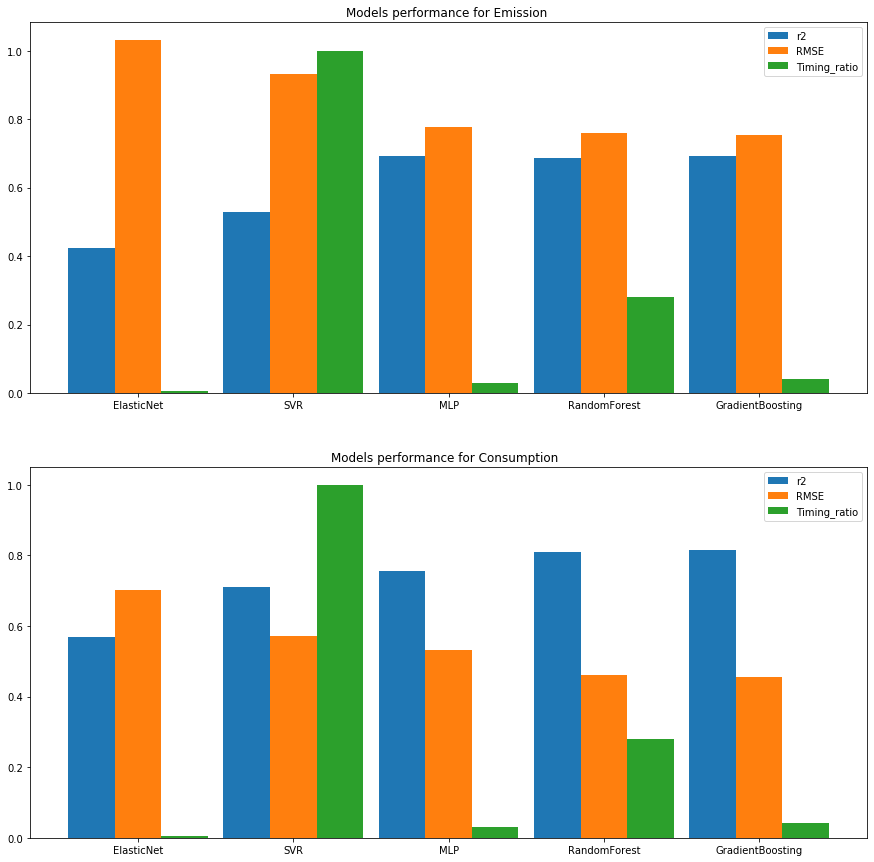

In [490]:
_X = np.arange(len(summary_emission.index))

fig, (ax1,ax2) = plt.subplots(2,1, figsize=[15,15])

ax1.set_title('Models performance for Emission ')
ax1.bar(_X -0.3,summary_emission['r2'], 0.3,label='r2')
ax1.bar(_X  ,-(summary_emission['neg_root_mean_squared_error']),0.3,label='RMSE')
ax1.bar(_X + 0.3,(summary_conso['Timing_ratio']),0.3,label='Timing_ratio')
ax1.legend()
ax1.set_xticks(_X)
ax1.set_xticklabels(summary_emission.index)

ax2.set_title('Models performance for Consumption  ')
ax2.bar(_X -0.3,summary_conso['r2'], 0.3,label='r2')
ax2.bar(_X  ,-(summary_conso['neg_root_mean_squared_error']),0.3,label='RMSE')
ax2.bar(_X + 0.3,(summary_conso['Timing_ratio']),0.3,label='Timing_ratio')
ax2.legend()
ax2.set_xticks(_X)
ax2.set_xticklabels(summary_conso.index)

In [566]:
#Saving the summary tables
summary_conso.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_4\summary_conso2.csv', index = True, header=True)
summary_emission.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_4\summary_emission2.csv', index = True, header=True)

In the end the best estimator (the one we will select for further study) is **GradientBoosting**

## Plot Prediction Vs Actual 

Plot the Prediction value against actual value to observe the error distribution

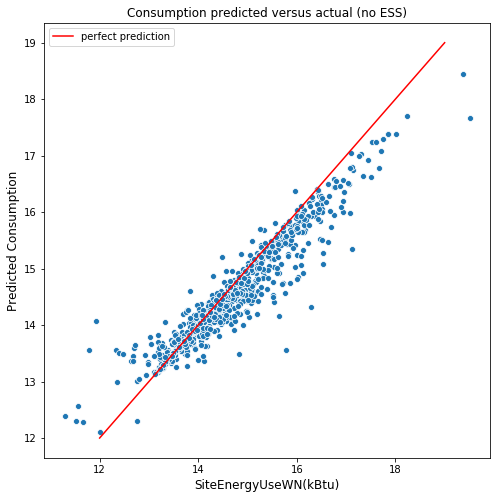

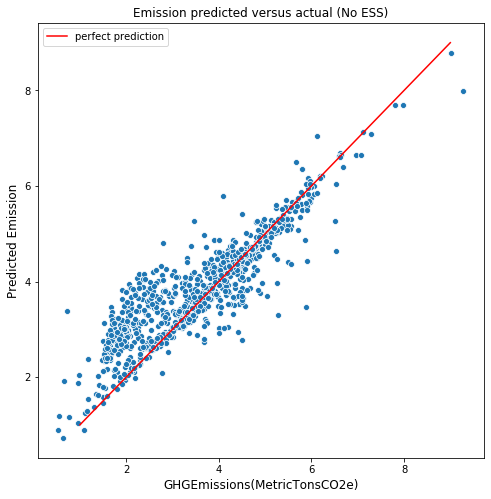

In [59]:
plt.figure(figsize=[8,8])
plt.title('Consumption predicted versus actual (no ESS)',fontsize=12)
plt.xlabel('Actual Consumption',fontsize=12)
plt.ylabel('Predicted Consumption',fontsize=12)
# sns.scatterplot(x=y_test_c,y=models_dict['gradientboosting'].predict(X_test_c))
sns.scatterplot(x=y_test_c,y=models_dict['gradientboosting'].predict(X_test_c))
plt.plot(range(12,20),range(12,20),color='r',label='perfect prediction')
plt.legend()

plt.figure(figsize=[8,8])
plt.title('Emission predicted versus actual (No ESS)',fontsize=12)
plt.xlabel('Actual Emission',fontsize=12)
plt.ylabel('Predicted Emission',fontsize=12)
sns.scatterplot(x=y_test_e,y=models_dict['gradientboosting_emission'].predict(X_test_e))
plt.plot(range(1,10),range(1,10),color='r',label='perfect prediction')
plt.legend()

For the consumption the error distribution looks regualar, but for emission it seems to have more diffuclty to predict small values 

# ENERGYSTARScore importance Study

## Train and Test score with ESS

### Consumption ESS

In [22]:
parameters = {"n_estimators": [100,150,200], 
              "learning_rate": [0.08,0.1,0.12,0.15],  
              "max_depth": np.linspace(5, 110, num = 6),
              "min_samples_leaf": [1,3,5,7,9],
              "max_features": ['auto','sqrt']
             } 



std = StandardScaler()
X_c_ESS = std.fit_transform(X_train_c_ESS)



gbr_ESS_grid = GridSearchCV(estimator = GradientBoostingRegressor(), 
                  param_grid = parameters,
                  scoring ='neg_root_mean_squared_error',
                  cv=5)


gbr_ESS_grid.fit(X_c_ESS,y_train_c)

best_esti_ess = gbr_ESS_grid.best_estimator_
a_ess = gbr_ESS_grid.best_score_
b_ess = gbr_ESS_grid.best_params_

print('Best RMSE: {}\nBest Params: {}'.format(a_ess,b_ess))
       

Best RMSE: -0.3541873128713
Best Params: {'learning_rate': 0.08, 'max_depth': 68.0, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


In [73]:
X_ESS = std.transform(X_test_c_ESS)

print('RMSE on test (GBR): ',math.sqrt(mean_squared_error(y_test_c_ESS,best_esti_ess.predict(X_ESS))))

RMSE on test (GBR):  0.3071596063588236


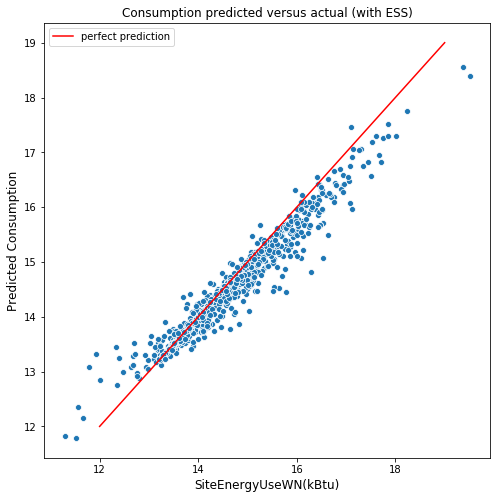

In [66]:
plt.figure(figsize=[8,8])
plt.title('Consumption predicted versus actual (with ESS)',fontsize=12)
plt.xlabel('Actual Consumption',fontsize=12)
plt.ylabel('Predicted Consumption',fontsize=12)
sns.scatterplot(x=y_test_c,y=best_esti_ess.predict(X_ESS))
plt.plot(range(12,20),range(12,20),color='r',label='perfect prediction')
plt.legend()



### Emission ESS

In [80]:
parameters = {"n_estimators": [100,150,200,250], 
              "learning_rate": [0.08,0.1,0.12,0.15],
              "max_depth": np.linspace(10, 110, num = 6),
              "min_samples_leaf": [1,3,5,7,9],
              "max_features":['auto', 'sqrt']
             } 




std = StandardScaler()
X_ESS = std.fit_transform(X_train_e_ESS)



boost_ESS_grid_e = GridSearchCV(estimator = GradientBoostingRegressor(), 
                  param_grid = parameters,
                  scoring ='neg_root_mean_squared_error',
                  cv=5)


boost_ESS_grid_e.fit(X_ESS,y_train_e_ESS)

best_esti_boost_e = boost_ESS_grid_e.best_estimator_
a_boost_e = boost_ESS_grid_e.best_score_
b_boost_e = boost_ESS_grid_e.best_params_

print('Best RMSE: {}\nBest Params: {}'.format(a_boost_e,b_boost_e))
       

Best RMSE: -0.705497044478359
Best Params: {'learning_rate': 0.08, 'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}


In [81]:
X_ESS_Test = std.transform(X_test_e_ESS)

print('RMSE Emission Test : ',math.sqrt(mean_squared_error(y_test_e_ESS,best_esti_boost_e.predict(X_ESS_Test))))


RMSE Emission Test :  0.6552217575727679


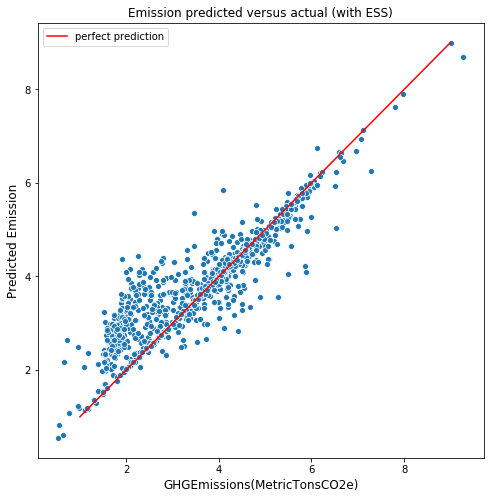

In [87]:
plt.figure(figsize=[8,8])
plt.title('Emission predicted versus actual (with ESS)',fontsize=12)
plt.xlabel('Actual Emission',fontsize=12)
plt.ylabel('Predicted Emission',fontsize=12)
sns.scatterplot(x=y_test_e,y=best_esti_boost_e.predict(X_ESS_Test))
plt.plot(range(1,10),range(1,10),color='r',label='perfect prediction')
plt.legend()

## Feature_Importances_

Here we can observ the feature_importances_ attribute of our GradientBoosting to have a first evaluation of ESS importance

In [69]:
# Create a dataframe which concatenates the feature name of the train and the coef feature attribute of our model
coef_features_ESS = best_esti_ess.feature_importances_
study_feature_ESS = pd.concat((pd.DataFrame(X_train_c_ESS.columns,columns=['Feature_name']),
                           pd.DataFrame(coef_features_ESS,columns=['Coef_feature'])),axis=1).sort_values(by='Coef_feature',ascending=False)
study_feature_ESS.head(10)

,Feature_name,Coef_feature
5,LargestPropertyUseTypeGFA,0.292558
43,Volume,0.155597
4,PropertyGFABuilding(s),0.143741
8,ENERGYSTARScore,0.085783
2,NumberofFloors,0.055094
6,SecondLargestPropertyUseTypeGFA,0.046115
3,PropertyGFAParking,0.045355
9,BuildingAge,0.036148
0,BuildingType_Consumption,0.029886
7,ThirdLargestPropertyUseTypeGFA,0.020468


We can see here that ESS is ranked 4th

In [70]:
study_feature_ESS['Coef_feature'].sum()

0.9999999999999999

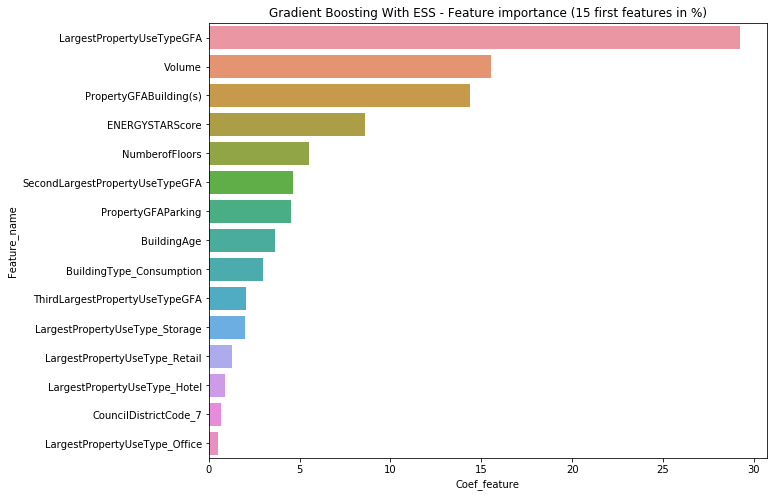

In [79]:
nbfeature=15

plt.figure(figsize=[10,8])
plt.title('Gradient Boosting With ESS - Feature importance ({} first features in %)'.format(nbfeature))
sns.barplot(x=(study_feature_ESS['Coef_feature']*100).head(nbfeature),y=study_feature_ESS['Feature_name'].head(nbfeature))

## RFE (Sklearn)

Recursive Feature Eliminator from sklearn will drop one feature by one, by order of importance and we can obtain the ranking as an attribute 

The difference with feature_importances_ is that everytime a feature is dropped, all feature importances are re_checked, so we can have some variation in the ranking if we compare those 2 

In [526]:
models

['gradientboosting',
 'Rfr',
 'elasticnet',
 'svr',
 'mlp',
 'gradientboosting_emission']

In [549]:
selector = RFE(models_dict[models[0]]['gradientboostingregressor'],n_features_to_select=1)
selector.fit(X_train_c_ESS,y_train_c)

RFE(estimator=GradientBoostingRegressor(max_depth=110.0, max_features='sqrt',
                                        min_samples_leaf=3),
    n_features_to_select=1)

In [550]:
selector.ranking_

array([ 6, 27,  5, 10,  2,  1,  8, 12,  4,  7, 26, 17, 13, 14, 11, 24, 15,
        9, 41, 43, 34, 25, 38, 28, 39, 30, 20, 35, 42, 40, 33, 36, 31, 44,
       37, 32, 23, 18, 21, 19, 22, 29, 16,  3])

In [552]:
ranking_RFE = pd.concat((pd.DataFrame(X_train_c_ESS.columns,columns=['Feature_name']),
                                   pd.DataFrame(selector.ranking_,columns=['Rank_feature'])),axis=1).sort_values(by='Rank_feature',ascending=True)
ranking_RFE

,Feature_name,Rank_feature
5,LargestPropertyUseTypeGFA,1
4,PropertyGFABuilding(s),2
43,Volume,3
8,ENERGYSTARScore,4
2,NumberofFloors,5
0,BuildingType_Consumption,6
9,BuildingAge,7
6,SecondLargestPropertyUseTypeGFA,8
17,LargestPropertyUseType_Storage,9
3,PropertyGFAParking,10


## Recursive elimination - Homemade

We would like to be able to plot the evolution of our prediction score with dropping features one by one, let's create a function to do so 

In [229]:
X_train_e.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge', 'LargestPropertyUseType_Entertainment',
       'LargestPropertyUseType_Hospital', 'LargestPropertyUseType_Hotel',
       'LargestPropertyUseType_Manufacturing', 'LargestPropertyUseType_Office',
       'LargestPropertyUseType_Restaurant', 'LargestPropertyUseType_Retail',
       'LargestPropertyUseType_School',
       'LargestPropertyUseType_Special Storage',
       'LargestPropertyUseType_Storage',
       'SecondLargestPropertyUseType_Entertainment',
       'SecondLargestPropertyUseType_Hospital',
       'SecondLargestPropertyUseType_Hotel',
       'SecondLargestPropertyUseType_Office',
       'SecondLargestPropertyUseType_Restaurant',
       'SecondLargestPropertyUseType_Retail',
       'SecondLargestPropertyUseType_School',
       'SecondLargestPropertyUseType_

___
We need to create a dictionnary which contains our OHE features as we want to drop the whole feature once one of the feature is considered as the less important

In [535]:
dict_ohe = {'LargestPropertyUseType_Entertainment':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Hospital':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Hotel':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Manufacturing':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Office':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Restaurant':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Retail':'LargestPropertyUseType_',
                 'LargestPropertyUseType_School':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Special Storage':'LargestPropertyUseType_',
                 'LargestPropertyUseType_Storage':'LargestPropertyUseType_',
              
                 'SecondLargestPropertyUseType_Entertainment':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Hospital':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Hotel':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Office':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Restaurant':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Retail':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_School':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Special Storage':'SecondLargestPropertyUseType_',
                 'SecondLargestPropertyUseType_Storage':'SecondLargestPropertyUseType_',
            
                 'ThirdLargestPropertyUseType_Entertainment':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Hospital':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Hotel':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Office':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Restaurant':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Retail':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_School':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Special Storage':'ThirdLargestPropertyUseType_',
                 'ThirdLargestPropertyUseType_Storage':'ThirdLargestPropertyUseType_',
              
                 'CouncilDistrictCode_1':'CouncilDistrictCode_',
                 'CouncilDistrictCode_2':'CouncilDistrictCode_',
                 'CouncilDistrictCode_3':'CouncilDistrictCode_',
                 'CouncilDistrictCode_4':'CouncilDistrictCode_',
                 'CouncilDistrictCode_5':'CouncilDistrictCode_',
                 'CouncilDistrictCode_6':'CouncilDistrictCode_',
                 'CouncilDistrictCode_7':'CouncilDistrictCode_'}


### Function creation 

Here the function will do the following task : 
   * Run a for loop (number of loop is the number of features)
   * in each loop, proceed with a GridSearchCV to find the best score for the model selected
   * once the gridsearch is done, drop the feature with the smallest importance
   * create and return an out_put table containing the feature dropped at each loop and the prediction score of the loop 

Function parameters: 
   * model : model to be used (Here GradientBoostingRegressor())
   * param : parameters to optimize 
   * score : score to use (here RMSE)
   * X : X_dataframe
   * y : target 
   * ohe : Ohe_dictionnary containing all Ohe_feature and the global corresponding feature
   * ohe_feature_number : number of global OHE feature
    

In [536]:
def RFE_analysis(model,param,score,X,y,ohe,ohe_feature_number):
    X_recurs = X.copy()
    y_recurs = y.copy()
    print('____________________\n   RFE ANALYSIS\n____________________\n')
    
    output_table = pd.DataFrame(columns=['Feature_dropped','Loop_score'])
    
    #calculate the total number of feature (number of feature not in the dictionnary OHE + OHE_global_feature number)
    looper = (~X_recurs.columns.isin(ohe)).sum()+ohe_feature_number
    
    for i in range(looper):
        print('--------------------------------------------------------------')
        print('Loop {} ongoing...'.format(i+1))
        std = StandardScaler()
        X_grid = std.fit_transform(X_recurs)
    
        mygrid = GridSearchCV(estimator = model, 
                              param_grid = param,
                              scoring = score,
                              cv=5)
        
        mygrid.fit(X_grid,y_recurs)
        
        output_table.loc[i,'Loop_score']=mygrid.best_score_
        
        
        
        coef_features = mygrid.best_estimator_.feature_importances_
        #study feature is a ranking of each feature from smallest importance to highest
        study_feature = pd.concat((pd.DataFrame(X_recurs.columns,columns=['Feature_name']),
                                   pd.DataFrame(coef_features,columns=['Coef_feature'])),axis=1).sort_values(by='Coef_feature',ascending=True)
        
        print(study_feature.sort_values(by='Coef_feature',ascending=False))
        print('\n Score RMSE: {}'.format(-mygrid.best_score_))
        
        #if less important feature is a ohe feature, drop all related ohe feature and write it in output table
        if study_feature.iloc[0,0] in ohe :
            print('Weakest feature: {}'.format(study_feature.iloc[0,0]))
            print('Dropped feature (OHE feature): {}'.format(ohe[study_feature.iloc[0,0]]))
            output_table.loc[i,'Feature_dropped']=ohe[study_feature.iloc[0,0]]
            X_recurs.drop(columns=list(X_recurs.columns[X_recurs.columns.str.startswith(ohe[study_feature.iloc[0,0]])]),inplace=True)
        
        #if not OHE feature only drops the feature and writes it in output table
        else :
            print('Weakest feature: {} => Dropped'.format(study_feature.iloc[0,0]))
            output_table.loc[i,'Feature_dropped']=study_feature.iloc[0,0]  
            X_recurs.drop(columns=study_feature.iloc[0,0],inplace=True)
        print('--------------------------------------------------------------\n\n')
            
            
    print('____________________\n RFE ANALYSIS DONE\n____________________\n')
    
    return output_table
                             
    
    
    

### Function test without ESS

In [537]:
model = GradientBoostingRegressor()
parameters = {"n_estimators": [100,150,200,250],  
              "max_depth": np.linspace(10, 110, num = 5),
              "min_samples_leaf": [1,3,5,7,9],
              "max_features":['auto', 'sqrt']
             }

# parameters = {"n_estimators": [1,100],  
#               "max_depth": np.linspace(10, 110, num = 2),
#               "min_samples_leaf": [1,3],
#               "max_features":['auto', 'sqrt']
#              } 

table_RFE = RFE_analysis(model,parameters,'neg_root_mean_squared_error',X_train_c,y_train_c,dict_ohe,4)

____________________
   RFE ANALYSIS
____________________

--------------------------------------------------------------
Loop 1 ongoing...
                                    Feature_name  Coef_feature
5                      LargestPropertyUseTypeGFA  2.099929e-01
4                         PropertyGFABuilding(s)  1.868668e-01
42                                        Volume  1.446669e-01
2                                 NumberofFloors  6.786435e-02
0                       BuildingType_Consumption  6.598651e-02
6                SecondLargestPropertyUseTypeGFA  6.506084e-02
3                             PropertyGFAParking  6.134107e-02
8                                    BuildingAge  5.573747e-02
7                 ThirdLargestPropertyUseTypeGFA  2.455703e-02
16                LargestPropertyUseType_Storage  2.048432e-02
10               LargestPropertyUseType_Hospital  1.266636e-02
12                 LargestPropertyUseType_Office  1.228193e-02
13                 LargestPropertyUseType

                       Feature_name  Coef_feature
4         LargestPropertyUseTypeGFA      0.296587
15                           Volume      0.221022
3            PropertyGFABuilding(s)      0.140370
5   SecondLargestPropertyUseTypeGFA      0.113300
7                       BuildingAge      0.061869
1                    NumberofFloors      0.057800
0          BuildingType_Consumption      0.043271
2                PropertyGFAParking      0.026667
6    ThirdLargestPropertyUseTypeGFA      0.009895
9             CouncilDistrictCode_2      0.007078
14            CouncilDistrictCode_7      0.005134
10            CouncilDistrictCode_3      0.004256
13            CouncilDistrictCode_6      0.003725
8             CouncilDistrictCode_1      0.003581
11            CouncilDistrictCode_4      0.003009
12            CouncilDistrictCode_5      0.002435

 Score RMSE: 0.5009583387775352
Weakest feature: CouncilDistrictCode_5
Dropped feature (OHE feature): CouncilDistrictCode_
--------------------------

In [538]:
table_RFE

,Feature_dropped,Loop_score
0,SecondLargestPropertyUseType_,-0.45439
1,ThirdLargestPropertyUseType_,-0.453372
2,NumberofBuildings,-0.459256
3,LargestPropertyUseType_,-0.457094
4,CouncilDistrictCode_,-0.500958
5,ThirdLargestPropertyUseTypeGFA,-0.51182
6,BuildingType_Consumption,-0.509038
7,SecondLargestPropertyUseTypeGFA,-0.53683
8,PropertyGFAParking,-0.543823
9,BuildingAge,-0.559187


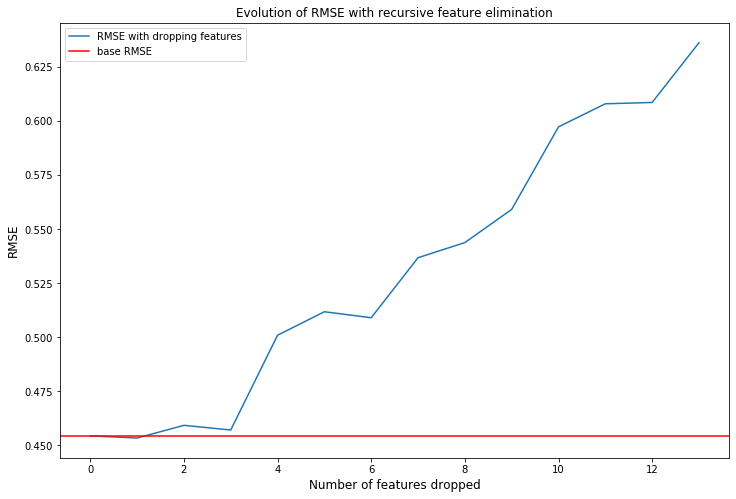

In [539]:
#We can simply plot the evolution of the score related to the number of features dropped
plt.figure(figsize=[12,8])
plt.plot(table_RFE.index,-table_RFE['Loop_score'],label='RMSE with dropping features')
plt.axhline(y=-table_RFE.iloc[0,1],color='r',label='base RMSE')
plt.ylabel('RMSE',fontsize=12)
plt.xlabel('Number of features dropped',fontsize=12)
plt.title('Evolution of RMSE with recursive feature elimination',fontsize=12)
plt.legend()


### RFE DIY With EnergyStarScore

In [540]:
table_RFE_ESS = RFE_analysis(model,parameters,'neg_root_mean_squared_error',X_train_c_ESS,y_train_c_ESS,dict_ohe,4)

____________________
   RFE ANALYSIS
____________________

--------------------------------------------------------------
Loop 1 ongoing...
                                    Feature_name  Coef_feature
43                                        Volume  2.281505e-01
5                      LargestPropertyUseTypeGFA  1.936922e-01
4                         PropertyGFABuilding(s)  1.190383e-01
8                                ENERGYSTARScore  9.190748e-02
6                SecondLargestPropertyUseTypeGFA  8.583786e-02
3                             PropertyGFAParking  7.071629e-02
9                                    BuildingAge  3.939465e-02
2                                 NumberofFloors  3.864660e-02
0                       BuildingType_Consumption  2.371398e-02
17                LargestPropertyUseType_Storage  1.663203e-02
7                 ThirdLargestPropertyUseTypeGFA  1.648154e-02
13                 LargestPropertyUseType_Office  1.443431e-02
14                 LargestPropertyUseType

                              Feature_name  Coef_feature
4                LargestPropertyUseTypeGFA      0.240609
3                   PropertyGFABuilding(s)      0.152473
17                                  Volume      0.142516
1                           NumberofFloors      0.125714
7                          ENERGYSTARScore      0.093737
5          SecondLargestPropertyUseTypeGFA      0.087909
0                 BuildingType_Consumption      0.039035
8                              BuildingAge      0.037961
16          LargestPropertyUseType_Storage      0.020864
2                       PropertyGFAParking      0.013272
13           LargestPropertyUseType_Retail      0.012130
12           LargestPropertyUseType_Office      0.007716
6           ThirdLargestPropertyUseTypeGFA      0.007677
11            LargestPropertyUseType_Hotel      0.006286
15  LargestPropertyUseType_Special Storage      0.003740
10         LargestPropertyUseType_Hospital      0.003271
14           LargestPropertyUse

In [541]:
table_RFE_ESS

,Feature_dropped,Loop_score
0,SecondLargestPropertyUseType_,-0.355177
1,ThirdLargestPropertyUseType_,-0.356343
2,NumberofBuildings,-0.355998
3,CouncilDistrictCode_,-0.354757
4,LargestPropertyUseType_,-0.360814
5,ThirdLargestPropertyUseTypeGFA,-0.410389
6,PropertyGFAParking,-0.413493
7,NumberofFloors,-0.415579
8,BuildingType_Consumption,-0.428755
9,BuildingAge,-0.468077


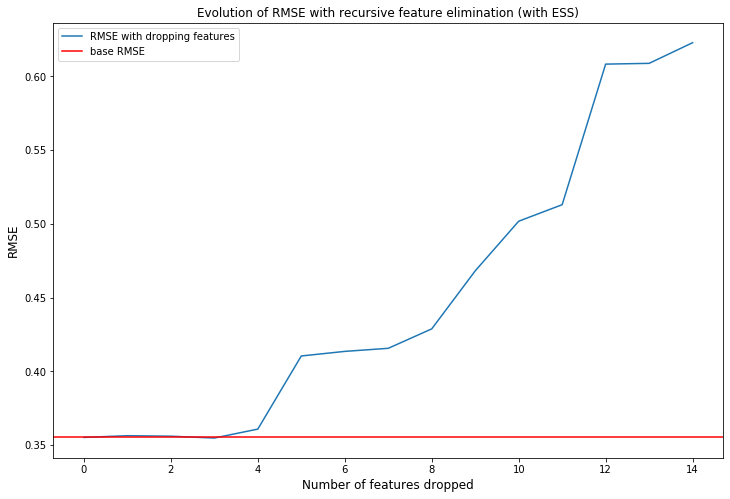

In [544]:
#We can simply plot the evolution of the score related to the number of features dropped
plt.figure(figsize=[12,8])
plt.plot(table_RFE_ESS.index,-table_RFE_ESS['Loop_score'],label='RMSE with dropping features')
plt.axhline(y=-table_RFE_ESS.iloc[0,1],color='r',label='base RMSE')
plt.ylabel('RMSE',fontsize=12)
plt.xlabel('Number of features dropped',fontsize=12)
plt.title('Evolution of RMSE with recursive feature elimination (with ESS)',fontsize=12)
plt.legend()


With the score we found with the ESS + this graph and ranking, we can say that the energy star score is relevant. 
We need to make a decision with studying the tradeoff between its importance in prediction and the efforts to populate this feature